# Supervised Learning -> Linear Regression

The first section (1 - 4) is identical across all regression models:
Keeping this part unchanged allows easy model comparison
and prevents pipeline-related mistakes.
Everything after that depends on the specific model.

1. Project setup and common pipeline
2. Dataset loading
3. Train-test split
4. Feature scaling (why we do it)
____
5. What is this model? (Intuition)
6. Model training
7. Model parameters interpretation
8. Predictions
9. Model evaluation
10. When to use it and when not to
11. Model persistence
12. Mathematical formulation (deep dive)

-----------------------------------------------------

## How this notebook should be read

This notebook is designed to be read **top to bottom**.

Before every code cell, you will find a short explanation describing:
- what we are about to do
- why this step is necessary
- how it fits into the overall process

The goal is not just to run the code,
but to understand what is happening at each step
and be able to adapt it to your own data.

-----------------------------------------------------

## What is Linear Regression? 

Linear Regression is one of the simplest and most widely used machine learning models.

At a high level, Linear Regression tries to **draw a straight line through the data**
in such a way that the line is as close as possible to all data points.

Each data point represents:
- some input values (features)
- a real observed output (target)

The model:
- places a line (or a plane, or a higher-dimensional surface)
- measures how far each data point is from that line
- adjusts the line to minimize the overall distance to all points

These distances represent prediction errors.

If the line is too high:
- predictions are systematically too large

If the line is too low:
- predictions are systematically too small

By minimizing the total error, the model learns the **overall trend** in the data.

Once the line is learned, the model can:
- take new input values
- project them onto the learned line
- return a predicted output value

-----------------------------------------------------

## Why we start with intuition

Understanding the intuition first is important because:

- the code will directly reflect this idea
- every training step is just an automated way of adjusting the line
- every prediction is a projection onto that line

If this mental model is clear,
the rest of the notebook becomes much easier to follow.

-----------------------------------------------------

## What you should expect from the results

Before training the model, it is important to set expectations.

With Linear Regression, you should expect:
- reasonable but not perfect predictions
- a simple and interpretable model
- performance that captures general trends, not complex patterns

If the model performs poorly:
- it does not necessarily mean something is wrong
- it may simply mean the relationship is not linear

This model is often used as:
- a baseline
- a reference point for more complex models

____________________________________________


## 1. Project setup and common pipeline

In this section we prepare everything that is shared across all regression models.

The goal is to:
- set up a clean and reproducible environment
- import all common dependencies
- define a standard pipeline that will not change when switching models

This part of the notebook is intentionally kept simple and consistent.
If something changes here, it should change in all models.


### Why having a common pipeline matters

Using the same pipeline for all models allows us to:
- compare models fairly
- avoid data leakage
- reduce implementation errors
- focus on understanding the model instead of debugging the setup

From this point on, every model will start from the exact same data preparation steps.


In [54]:
#   Used for numerical operations and data manipulation.
import numpy as np 
import pandas as pd

#  Provides a real-world regression dataset for demonstration purposes.
from sklearn.datasets import fetch_california_housing

#  Ensures a clean separation between training and test data.
from sklearn.model_selection import train_test_split

#  Applies feature scaling to ensure numerical stability and pipeline consistency.
from sklearn.preprocessing import StandardScaler

#  Used later to assess model performance.
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error

# Used for stabil path.
from pathlib import Path

#  Used to save trained models and preprocessing objects.
import joblib



# ____________________________________

## 2. Dataset loading

In this section we load the dataset that will be used throughout the notebook.

The purpose of this step is to:
- obtain real data to work with
- clearly separate input features from the target variable
- create a structure that can be easily replaced with custom datasets

At this stage, no modeling is involved.
We are only defining what the model will learn from.


### About the dataset

We use the California Housing dataset, a classic regression dataset.

Each row represents a housing district in California.
Each column represents a numerical feature describing that district.
The target variable is a continuous value representing house prices.


In [55]:
data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target


### What we obtained

- `X`  
  A table of input features used by the model to make predictions.

- `y`  
  The target variable we want the model to predict.

This separation is fundamental:
- the model learns patterns from `X`
- the model is evaluated by comparing predictions to `y`

Adapting this step to your own data:
`X` should contain only feature columns
`y` should contain the target variable

# ____________________________________

## 3. Train-test split

In this section we split the dataset into two separate parts:
- a training set
- a test set

This step is fundamental in machine learning and applies to almost every model.


### Why we split the data

The goal of a machine learning model is not to memorize data,
but to make good predictions on **new, unseen data**.

If we trained and evaluated the model on the same data:
- we would get overly optimistic results
- we would not know how well the model generalizes

By splitting the data:
- the training set is used to learn patterns
- the test set is used only for evaluation


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


### What these parameters mean

- `test_size=0.2`  
  20% of the data is reserved for testing,  
  80% is used for training.

That split can be change based on the dataset.

### What we have after this step

- `X_train`, `y_train`  
  Data used to train the model.

- `X_test`, `y_test`  
  Data kept aside and used only for evaluation.

From this point on:
- the model must never see the test data during training
- all learning happens exclusively on the training set


# ____________________________________

## 4. Feature scaling (why we do it)

In this section we apply feature scaling to the input data.

Feature scaling means transforming the numerical features
so that they all follow a similar scale.


### Why feature scaling is important

In many datasets, features can have very different ranges.

For example:
- one feature may range between 0 and 1
- another may range between 0 and 100,000

Without scaling:
- features with larger values can dominate the learning process
- numerical computations may become unstable

### Does Linear Regression require scaling?

Strictly speaking:
- Linear Regression **can work without feature scaling**

However, we still apply scaling because:

1. Numerical stability 
2. Pipeline consistency  
   Many other models (Ridge, Lasso, SGD, SVM) **require** scaled features.
   Keeping scaling in the pipeline avoids changing code later
3. Better coefficient interpretation  




### Important rule: fit only on training data

The scaler must be:
- fitted on the training data
- applied to both training and test data

In [57]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### What we have after this step

- `X_train_scaled`  
  Scaled features used to train the model.

- `X_test_scaled`  
  Scaled features

Now we are ready to introduce the model.


# ____________________________________

## 5. What is this model? 

Before training any model, it is important to understand
what the model is trying to do conceptually.

Linear Regression is one of the simplest machine learning models,
and for this reason it is often the best place to start.


### The core idea

Linear Regression tries to model the relationship between input features
and a continuous target value by drawing a straight line through the data.

This line represents the best overall trend that explains how the inputs
are related to the output.


### Thinking in simple terms

Imagine plotting your data points on a chart.

Each point represents:
- some input values (features)
- a real observed output (target)

Linear Regression:
- draws a line through these points
- measures how far each point is from the line
- moves the line to reduce the overall distance to all points

These distances represent prediction errors.

The model keeps adjusting the line until the total error is as small as possible.


### From line to prediction

Once the line is learned, the model can make predictions.

For a new input:
- the model looks at its position on the horizontal axis
- projects it onto the learned line
- reads the corresponding value on the vertical axis

This projected value is the model's prediction.


# ____________________________________

## 6. Model training

In this section we train the Linear Regression model.

Training a model means finding the parameters of the line
that best fit the training data.

This process is fully automated by the library scikit-learn, Linear Regression.

In [58]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Train the model on the scaled training data
model.fit(X_train_scaled, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


### What we have after training

After this step:
- the model has learned the best-fitting line
- the parameters of the model are fixed
- the model is ready to make predictions

From this point on:
- we do not modify the model using test data
- the test set is used only for evaluation


# ____________________________________

## 7. Model parameters interpretation

In this section we examine the parameters learned by the model.

These parameters describe the position of the line
that Linear Regression has fitted to the data.


### What parameters does Linear Regression learn?

A Linear Regression model learns:
- one coefficient for each input feature
- one intercept term

Together, these values fully define the model.


In [59]:
coefficients = pd.Series(model.coef_, index=X.columns)
intercept = model.intercept_

coefficients, intercept


(MedInc        0.854383
 HouseAge      0.122546
 AveRooms     -0.294410
 AveBedrms     0.339259
 Population   -0.002308
 AveOccup     -0.040829
 Latitude     -0.896929
 Longitude    -0.869842
 dtype: float64,
 np.float64(2.071946937378881))

### How to interpret the coefficients

Each coefficient represents:
- the expected change in the target variable
- for a one-unit increase in that feature
- while keeping all other features constant

Because we used scaled features:
- coefficients are directly comparable
- larger absolute values indicate stronger influence


### Intercept explained

The intercept represents:
- the predicted value when all input features are equal to zero

With scaled features:
- this corresponds to the prediction for an “average” data point


### Why parameter interpretation matters

Interpreting parameters allows us to:
- understand which features influence predictions the most
- detect unexpected relationships in the data
- build trust in the model’s behavior

This is one of the main strengths of Linear Regression.


### Extra:
### What this plot shows

- Each point represents a real data sample
- The x-axis shows one selected feature
- The y-axis shows the target value
- The line represents the model's predictions

This is NOT the full model,
but a simplified view that helps interpretation.

To visualize the effect of a single feature, we create artificial inputs.

All features are fixed at their average value (0 after scaling),
except one feature which is allowed to vary.

This allows us to observe how the model responds to changes
in a single feature while keeping everything else constant.



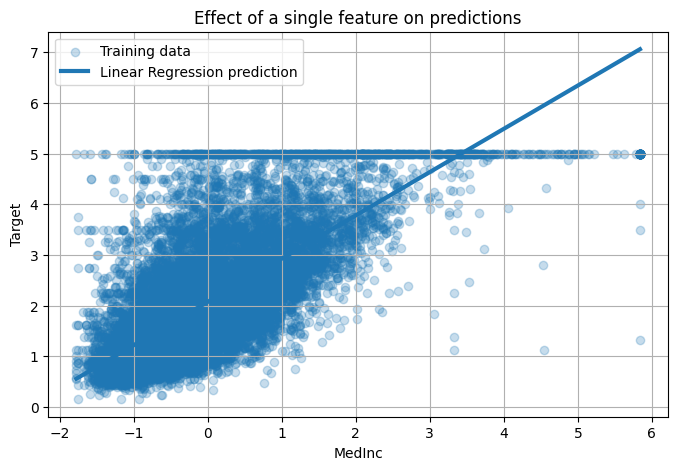

In [60]:
import matplotlib.pyplot as plt

# Select feature to visualize
feature_name = X.columns[0]
feature_index = 0

# Create artificial input data
X_vis = np.zeros((100, X_train_scaled.shape[1]))
X_vis[:, feature_index] = np.linspace(
    X_train_scaled[:, feature_index].min(),
    X_train_scaled[:, feature_index].max(),
    100
)

# Predictions
y_vis_pred = model.predict(X_vis)

# Plot
plt.figure(figsize=(8, 5))

plt.scatter(
    X_train_scaled[:, feature_index],
    y_train,
    alpha=0.25,
    label="Training data"
)

plt.plot(
    X_vis[:, feature_index],
    y_vis_pred,
    linewidth=3,
    label="Linear Regression prediction"
)

plt.xlabel(feature_name)
plt.ylabel("Target")
plt.title("Effect of a single feature on predictions")
plt.legend()
plt.grid(True)
plt.show()


# ____________________________________

## 8. Predictions

In this section we use the trained model to make predictions.

This is the step where the model behaves as it would in a real-world scenario:
it receives input data and returns predicted values.


In [61]:
# Generate predictions on the test set

y_pred = model.predict(X_test_scaled)


### What we obtained

- `y_pred` contains the predicted target values
- each prediction corresponds to one test sample
- predictions are continuous values

These predictions can now be compared
with the real target values (`y_test`)
to evaluate how well the model performs.


# ____________________________________

## 9. Model evaluation

In this section we evaluate how well the model performs
by comparing its predictions with the real target values.

Evaluation allows us to move from intuition
to measurable, objective results.


### Why evaluation is necessary

A model that produces predictions is not necessarily a good model.

We need evaluation metrics to:
- measure prediction errors
- compare different models
- understand the limits of our approach

Evaluation answers the question:
"How far are the predictions from reality?"


In [62]:
# Compute evaluation metrics

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

mae, mse, rmse, r2


(0.5332001304956565,
 0.5558915986952444,
 np.float64(0.7455813830127764),
 0.5757877060324508)

### Metrics explanation

- **Mean Squared Error (MSE)**  
  Measures the average squared difference between predictions and real values.  
  Larger errors are penalized more heavily.

- ### Mean Absolute Error (MAE)
  MAE measures the average absolute difference
  between predicted and real values.

- **Root Mean Squared Error (RMSE)**  
  Square root of MSE.  
  Expressed in the same units as the target variable, making it easier to interpret.

- **R² score**  
  Indicates how much of the variance in the target variable
  is explained by the model.


### How to interpret the results

There is no single "good" value that applies to all problems.

However, in general:
- lower MSE and RMSE indicate better predictions
- higher R² indicates better explanatory power

For Linear Regression, you should expect:
- reasonable but imperfect performance
- a solid baseline result
- clear room for improvement with more complex models


# ____________________________________

## 10. When to use it and when not to

Understanding when a model should be used
is as important as knowing how to train it.

Linear Regression is a simple and powerful model,
but only when its assumptions are reasonably satisfied.


### When Linear Regression is a good choice

Linear Regression works well when:

- The relationship between features and target is approximately linear
- The target variable is continuous
- Interpretability is important
- You need a fast and simple baseline model
- You want to understand feature influence clearly

It is often used as:
- a first model
- a reference point
- a benchmark for more complex methods


### Typical warning signs

You should be cautious if:

- Residuals show clear patterns
- Predictions are consistently biased
- Errors grow significantly for certain ranges
- Performance is very poor compared to simple alternatives

In these cases, a linear model may be too restrictive.


# ____________________________________

## 11. Model persistence

In this section we save the trained model and the preprocessing steps.

Model persistence allows us to:
- reuse the model without retraining
- deploy it in production
- share it with others


### Important rule: save the preprocessing too

A trained model is not enough on its own.

If the data was scaled during training:
- the same scaler must be applied to new data
- otherwise predictions will be incorrect

For this reason:
the model and the scaler must always be saved together.


In [64]:
# Define model directory
model_dir = Path("models/supervised_learning/regression/linear_regression")

# Create directory if it does not exist
model_dir.mkdir(parents=True, exist_ok=True)

# Save model and scaler
joblib.dump(model, model_dir / "linear_regression_model.joblib")
joblib.dump(scaler, model_dir / "scaler.joblib")

['models\\supervised_learning\\regression\\linear_regression\\scaler.joblib']

# ____________________________________

## 12. Mathematical formulation

This section provides a deeper mathematical explanation
of Linear Regression.

It is not required to use the model,
but it helps understand what happens under the hood
and demonstrates the theoretical foundation of the method.


### Model equation

Linear Regression assumes that the target variable
can be expressed as a linear combination of the input features.

The model is defined as:

ŷ = w₁x₁ + w₂x₂ + ... + wₙxₙ + b

Where:
- xᵢ are the input features
- wᵢ are the learned coefficients
- b is the intercept
- ŷ is the predicted value


### Objective function

The goal of Linear Regression is to find the parameters
(w₁, w₂, ..., wₙ, b) that minimize the prediction error.

The most common objective function is the Mean Squared Error (MSE):

J(w, b) = (1 / n) Σ (yᵢ − ŷᵢ)²

This function penalizes large errors more heavily
and leads to a smooth, convex optimization problem.


### Analytical solution in scikit-learn

In scikit-learn, Linear Regression is solved analytically.

Instead of using gradient descent,
the optimal parameters are computed directly
using linear algebra techniques
(such as matrix decomposition).

This makes training:
- fast
- stable
- deterministic


### Final takeaway

Linear Regression is simple by design.

Its strength lies in:
- clarity
- interpretability
- strong theoretical guarantees

More advanced models often extend or modify
this exact formulation
by adding constraints or regularization.


# ____________________________________
## Final summary – Code only

The following cell contains the complete pipeline
from data loading to model persistence.

No explanations are provided here on purpose.

This section is intended for:
- quick execution
- reference
- reuse in scripts or applications

If you want to understand what each step does and why,
read the notebook from top to bottom.


In [ ]:
# ====================================
# Imports
# ====================================

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from pathlib import Path
import joblib


# ====================================
# Dataset loading
# ====================================

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target


# ====================================
# Train-test split
# ====================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


# ====================================
# Feature scaling
# ====================================

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ====================================
# Model initialization
# ====================================

lr_model = LinearRegression()


# ====================================
# Model training
# ====================================

lr_model.fit(X_train_scaled, y_train)


# ====================================
# Predictions
# ====================================

y_pred_lr = lr_model.predict(X_test_scaled)


# ====================================
# Model evaluation
# ====================================

mae = mean_absolute_error(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lr)

mae, mse, rmse, r2


# ====================================
# Model persistence
# ====================================

model_dir = Path("models/supervised_learning/regression/linear_regression")
model_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(lr_model, model_dir / "linear_regression_model.joblib")
joblib.dump(scaler, model_dir / "scaler.joblib")
